In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter

In [2]:
# Load the Metrics Excel file for macOS
metrics_file_path = (r"/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /BiomechanicsExercise_Metrics_Limited.xlsm")
signals_file_path = (r"/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /BiomechanicsExercise_Signals_New_Limited.xlsm")

metrics_df = pd.read_excel(metrics_file_path, sheet_name=None)

# Read the sheets
metrics_df = pd.read_excel(metrics_file_path, sheet_name='BiomechanicsExercise_Metrics_Li')
signals_df = pd.read_excel(signals_file_path, sheet_name='BiomechanicsExercise_Signals_Ne')

# Display the sheet names to understand the structure
metrics_df.keys()
signals_df.keys()

def x_dot(time, position):
    slope = np.gradient(position, time)
    return slope

# Extract the correct sheet from Signals into a DataFrame
signals_df_corrected = signals_df
# Load the specific sheet into a DataFrame correctly
metrics_df_corrected = metrics_df

# Select relevant columns correctly from Metrics
metrics_relevant_corrected = metrics_df_corrected[['INNING', 'PITCHER_PITCH_COUNT', 'PITCH_TYPE', 'RELEASE_SPEED', 'SPIN_RATE']]

# Merge Signals and Metrics DataFrames
merged_data_corrected = pd.merge(signals_df_corrected, metrics_relevant_corrected, how='left', on=['INNING', 'PITCH_TYPE', 'PITCHER_PITCH_COUNT'])

In [15]:
import pandas as pd

# Define columns that should be excluded from the averaging process
exclude_columns = ['INNING', 'PITCHER_PITCH_COUNT', 'PITCHER_NAME_LAST_FIRST', 'PITCH_TYPE']

# Select numeric columns to include in the averaging process (exclude non-numeric or unwanted columns)
numeric_columns = [col for col in merged_data_corrected.columns if col not in exclude_columns]

# Step 1: Group by INNING and calculate the mean for the numeric columns only
averaged_data = merged_data_corrected.groupby('INNING')[numeric_columns].mean().reset_index()

# Step 2: Extract one representative row for non-averaged columns (`INNING`, `PITCH_TYPE`, etc.)
# Keep one row per INNING that has context columns such as `PITCH_TYPE` and `PITCHER_NAME_LAST_FIRST`
representative_data = merged_data_corrected.drop_duplicates(subset=['INNING'])

# Step 3: Merge the representative columns back with the averaged signals
final_averaged_data = pd.merge(representative_data[['INNING', 'PITCH_TYPE', 'PITCHER_NAME_LAST_FIRST', 'PITCHER_PITCH_COUNT']], 
                               averaged_data, on='INNING', how='right')

# Step 4: Create a dictionary to hold separate dataframes for each INNING
average_sync_data_dict = {}

# Step 5: Loop through each unique INNING to create separate sheets
for inning in final_averaged_data['INNING'].unique():
    sheet_name = f"Inning_{inning}"
    average_sync_data_dict[sheet_name] = final_averaged_data[final_averaged_data['INNING'] == inning]

# Step 6: Save the averaged signals data to separate sheets for each INNING
output_sync_file_path = "/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /averaged_by_inning_data.xlsx"
with pd.ExcelWriter(output_sync_file_path) as writer:
    for sheet_name, data in average_sync_data_dict.items():
        data.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Averaged data by inning saved to: {output_sync_file_path}")


Averaged data by inning saved to: /Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /averaged_by_inning_data.xlsx


In [14]:
# Ensure that merged_data_corrected is correctly defined
# Select only numeric columns for averaging
numeric_columns = merged_data_corrected.select_dtypes(include=[float, int]).columns

# Include the necessary grouping columns
grouping_columns = ['INNING', 'PITCH_TYPE', 'FRAME']

# Filter the DataFrame to include only the numeric columns and grouping columns
numeric_merged_data = merged_data_corrected[grouping_columns + list(numeric_columns)]

# Step 1: Group by INNING, PITCH_TYPE, and FRAME, and calculate the mean for numeric columns
averaged_data = numeric_merged_data.groupby(['INNING', 'PITCH_TYPE', 'FRAME']).mean().reset_index()

# Step 2: Create a dictionary to hold separate dataframes for each INNING and PITCH_TYPE
average_sync_data_dict = {}

# Step 3: Loop through each unique INNING and PITCH_TYPE combination to create separate sheets
for (inning, pitch_type), group_data in averaged_data.groupby(['INNING', 'PITCH_TYPE']):
    sheet_name = f"{pitch_type}_Inning_{inning}"
    average_sync_data_dict[sheet_name] = group_data

# Step 4: Save the averaged signals data to separate sheets for each INNING and PITCH_TYPE
output_sync_file_path = "/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /averaged_sync_data_corrected.xlsx"
with pd.ExcelWriter(output_sync_file_path) as writer:
    for sheet_name, data in average_sync_data_dict.items():
        data.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Averaged synchronized data saved to: {output_sync_file_path}")



ValueError: Grouper for 'INNING' not 1-dimensional

In [8]:
'''# SYNCRONIZE DATA BY SHOULDER INT ROT VELO...no work 
def find_sync_points(pitch_df):
    # Check if the DataFrame is not empty
    if pitch_df.empty:
        print("Empty DataFrame encountered in find_sync_points.")
        return pd.DataFrame()  # Return an empty DataFrame if the input is empty

    # Step 1: Calculate the gradient (velocity) of Shoulder Z with respect to ZERO_TIME
    try:
        # Ensure there are enough frames before calculating the gradient
        if len(pitch_df) < 150:
            print(f"Group too small for gradient calculation: {pitch_df[['INNING', 'PITCH_TYPE']].iloc[0]}")
            return pd.DataFrame()

        # Calculate the shoulder velocity using the gradient
        shoulder_velocity = np.gradient(pitch_df['SHOULDER_Z'].values, pitch_df['ZERO_TIME'].values)
    except Exception as e:
        print(f"Error calculating gradient for group: {pitch_df[['INNING', 'PITCH_TYPE']].iloc[0]} - {str(e)}")
        return pd.DataFrame()
    
    # Step 2: Create a new series to hold shoulder velocities and use for easier manipulation
    shoulder_velocity_series = pd.Series(shoulder_velocity, index=pitch_df.index)

    # Step 3: Use where to filter for values only after 150 frames (and set others to NaN)
    if len(shoulder_velocity_series) < 150:
        print(f"Insufficient length for shoulder velocity series: {pitch_df[['INNING', 'PITCH_TYPE']].iloc[0]}")
        return pd.DataFrame()
    
    shoulder_velocity_filtered = shoulder_velocity_series.where(shoulder_velocity_series.index >= 150, np.nan)

    # Step 4: Find the index of the maximum value in the filtered series
    try:
        max_velocity_idx = shoulder_velocity_filtered.idxmax()
    except ValueError:
        print(f"Could not find maximum velocity index for group: {pitch_df[['INNING', 'PITCH_TYPE']].iloc[0]}")
        return pd.DataFrame()

    # Check that the max_velocity_idx is valid
    if max_velocity_idx is None or max_velocity_idx >= len(pitch_df):
        print(f"Invalid max_velocity_idx found for group: {pitch_df[['INNING', 'PITCH_TYPE']].iloc[0]}")
        return pd.DataFrame()

    # Get the corresponding ZERO_TIME value for the peak shoulder internal rotation velocity
    max_zero_time = pitch_df['ZERO_TIME'].iloc[max_velocity_idx]
    print(f"Max Shoulder Internal Rotation Velocity occurs at ZERO_TIME: {max_zero_time} for pitch {pitch_df['PITCH_TYPE'].iloc[0]} in inning {pitch_df['INNING'].iloc[0]}")

    # Extract from the start of the pitch to the maximum shoulder internal rotation velocity index
    return pitch_df.iloc[:max_velocity_idx+1].reset_index(drop=True)  # Include all data up to the max internal rotation velocity

# Ensure `synchronized_data` is created using find_sync_points for each grouped set
synchronized_data = (
    merged_data_corrected.groupby(['INNING', 'PITCH_TYPE'])
    .apply(find_sync_points)
    .reset_index(drop=True)
)

# Check if synchronized_data is successfully created and not empty
if synchronized_data.empty:
    print("No synchronized data created. Check your grouping or function logic.")
else:
    print("Synchronized data successfully created.")

# Step 3: Save synchronized signals data to separate sheets for each inning and pitch type
sync_data_dict = {}

# Loop through each unique inning and pitch type to create separate sheets
for (inning, pitch_type), group_data in synchronized_data.groupby(['INNING', 'PITCH_TYPE']):
    if not group_data.empty:
        sheet_name = f"{pitch_type}_Inning_{inning}"
        sync_data_dict[sheet_name] = group_data

# Save the synchronized signals data into separate sheets for each pitch type and inning
output_sync_file_path = "/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /sync_data.xlsx"
with pd.ExcelWriter(output_sync_file_path) as writer:
    for sheet_name, data in sync_data_dict.items():
        data.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Synchronized data saved to: {output_sync_file_path}")

'''

Invalid max_velocity_idx found for group: INNING                1
PITCH_TYPE    Curveball
Name: 0, dtype: object
Invalid max_velocity_idx found for group: INNING               1
PITCH_TYPE    Fastball
Name: 602, dtype: object
Invalid max_velocity_idx found for group: INNING               7
PITCH_TYPE    Changeup
Name: 4816, dtype: object
Invalid max_velocity_idx found for group: INNING                7
PITCH_TYPE    Curveball
Name: 301, dtype: object
Max Shoulder Internal Rotation Velocity occurs at ZERO_TIME: 0.004856 for pitch Fastball in inning 7
Invalid max_velocity_idx found for group: INNING             7
PITCH_TYPE    Sinker
Name: 2107, dtype: object
Synchronized data successfully created.
Synchronized data saved to: /Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /sync_data.xlsx


/var/folders/f7/j3q3z14j7s958d7jly0pll6w0000gn/T/ipykernel_83174/2805160117.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(find_sync_points)


In [7]:
# Check unique pitch types and innings before applying the function
unique_combinations = merged_data_corrected[['INNING', 'PITCH_TYPE']].drop_duplicates()
print("Unique Pitch Type and Inning Combinations:\n", unique_combinations)

# Apply the find_sync_points function and check for issues
synchronized_data = merged_data_corrected.groupby(['INNING', 'PITCH_TYPE']).apply(find_sync_points).reset_index(drop=True)

# Check which groups are missing or resulted in empty DataFrames
group_status = synchronized_data.groupby(['INNING', 'PITCH_TYPE']).size().reset_index(name='Count')
print("Group Status After Synchronization:\n", group_status)

# Check if any group has a count of zero (empty DataFrame)
empty_groups = group_status[group_status['Count'] == 0]
if not empty_groups.empty:
    print("Empty Groups Found:\n", empty_groups)
else:
    print("No Empty Groups Found.")


Unique Pitch Type and Inning Combinations:
       INNING PITCH_TYPE
0          1  Curveball
301        7  Curveball
602        1   Fastball
1204       7   Fastball
2107       7     Sinker
4816       7   Changeup
Invalid max_velocity_idx found for group: INNING                1
PITCH_TYPE    Curveball
Name: 0, dtype: object
Invalid max_velocity_idx found for group: INNING               1
PITCH_TYPE    Fastball
Name: 602, dtype: object
Invalid max_velocity_idx found for group: INNING               7
PITCH_TYPE    Changeup
Name: 4816, dtype: object
Invalid max_velocity_idx found for group: INNING                7
PITCH_TYPE    Curveball
Name: 301, dtype: object
Max Shoulder Internal Rotation Velocity occurs at ZERO_TIME: 0.004856 for pitch Fastball in inning 7
Invalid max_velocity_idx found for group: INNING             7
PITCH_TYPE    Sinker
Name: 2107, dtype: object
Group Status After Synchronization:
    INNING PITCH_TYPE  Count
0     7.0   Fastball   1206
No Empty Groups Found.


/var/folders/f7/j3q3z14j7s958d7jly0pll6w0000gn/T/ipykernel_83174/3575716751.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  synchronized_data = merged_data_corrected.groupby(['INNING', 'PITCH_TYPE']).apply(find_sync_points).reset_index(drop=True)


In [190]:
# A TRIMMING FUNCTION IN CASE I NEEDED TO TRIM THE MARKERED DATA 
'''# Define a function to trim NaN values from the beginning and end of each pitch
def trim_nan_values(pitch_df):
    # Remove leading and trailing NaN values
    trimmed_df = pitch_df.dropna(how='all').reset_index(drop=True)
    # Check and remove NaNs at the start and end
    first_valid_index = trimmed_df.apply(pd.Series.first_valid_index)
    last_valid_index = trimmed_df.apply(pd.Series.last_valid_index)

    # Select the subset without NaNs at the beginning or end
    start = max(first_valid_index.min(), 0)  # Get the first non-NaN index across all columns
    end = min(last_valid_index.max(), len(trimmed_df) - 1)  # Get the last non-NaN index across all columns
    return trimmed_df.loc[start:end].reset_index(drop=True)
cleaned_signals_df = trim_nan_values(signals_df)
cleaned_signals_df.to_excel("/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /signals_trimmed.xlsx", index=False)
'''

'# Define a function to trim NaN values from the beginning and end of each pitch\ndef trim_nan_values(pitch_df):\n    # Remove leading and trailing NaN values\n    trimmed_df = pitch_df.dropna(how=\'all\').reset_index(drop=True)\n    # Check and remove NaNs at the start and end\n    first_valid_index = trimmed_df.apply(pd.Series.first_valid_index)\n    last_valid_index = trimmed_df.apply(pd.Series.last_valid_index)\n\n    # Select the subset without NaNs at the beginning or end\n    start = max(first_valid_index.min(), 0)  # Get the first non-NaN index across all columns\n    end = min(last_valid_index.max(), len(trimmed_df) - 1)  # Get the last non-NaN index across all columns\n    return trimmed_df.loc[start:end].reset_index(drop=True)\ncleaned_signals_df = trim_nan_values(signals_df)\ncleaned_signals_df.to_excel("/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /signals_trim

In [51]:
# Group by INNING and PITCH_TYPE, then calculate average pitch speed
average_speed_per_inning = metrics_df.groupby(['INNING', 'PITCH_TYPE'])['RELEASE_SPEED'].mean().reset_index()
average_spin_per_inning = metrics_df.groupby(['INNING', 'PITCH_TYPE'])['SPIN_RATE'].mean().reset_index()

# Display the results
print(average_speed_per_inning)
print(average_spin_per_inning)

   INNING PITCH_TYPE  RELEASE_SPEED
0       1  Curveball      82.260517
1       1   Fastball      95.544671
2       7   Changeup      86.450300
3       7  Curveball      80.970660
4       7   Fastball      93.642100
5       7     Sinker      93.298000
   INNING PITCH_TYPE    SPIN_RATE
0       1  Curveball  2955.646667
1       1   Fastball  2233.980000
2       7   Changeup  1999.980000
3       7  Curveball  2999.780000
4       7   Fastball  2278.180000
5       7     Sinker  2112.646667


In [182]:
# Extract the correct sheet from Signals into a DataFrame
signals_df_corrected = signals_df
# Load the specific sheet into a DataFrame correctly
metrics_df_corrected = metrics_df
# Now select the relevant columns correctly

# Select relevant columns correctly from Metrics
metrics_relevant_corrected = metrics_df_corrected[['INNING', 'PITCHER_PITCH_COUNT', 'PITCH_TYPE', 'RELEASE_SPEED', 'SPIN_RATE']]

# Merge Signals and Metrics DataFrames
merged_data_corrected = pd.merge(signals_df_corrected, metrics_relevant_corrected, how='left', on=['INNING', 'PITCH_TYPE', 'PITCHER_PITCH_COUNT'])

# Calculate velocity columns without taking absolute values
if 'ZERO_TIME' in merged_data_corrected.columns:
    # Calculate derivatives using the provided function
    merged_data_corrected['PELVIS_Z_DERIVATIVE'] = x_dot(merged_data_corrected['ZERO_TIME'], merged_data_corrected['PELVIS_Z'])
    merged_data_corrected['TRUNK_Z_DERIVATIVE'] = x_dot(merged_data_corrected['ZERO_TIME'], merged_data_corrected['TRUNK_Z'])
    merged_data_corrected['SHOULDER_Z_DERIVATIVE'] = x_dot(merged_data_corrected['ZERO_TIME'], merged_data_corrected['SHOULDER_Z'])
    merged_data_corrected['ELBOW_X_DERIVATIVE'] = x_dot(merged_data_corrected['ZERO_TIME'], merged_data_corrected['ELBOW_X'])
else:
    print("The column 'ZERO_TIME' is not available for derivative calculation.")

# Update the aggregation dictionary to include new derivative columns
aggregation_dict_derivative = {
    'RELEASE_SPEED': 'mean',  # Average pitch speed
    'SPIN_RATE': 'mean',  # Average spin rate
    # Elbow flexion/extension
    'ELBOW_X': [
        ('Max Flexion', 'max'),  # Maximum flexion (positive values)
        ('Min Extension', 'min')  # Minimum extension (negative values)
    ],
    # Peak elbow extension derivative
    'ELBOW_X_DERIVATIVE': 'max',
    # Front knee hyperextension/flexion
    'FRONTKNEE_X': [
        ('Max Hyperextension', 'max'),  # Max value for hyperextension
        ('Min Flexion', 'min')  # Min value for flexion
    ],
    # Back knee hyperextension/flexion
    'BACKKNEE_X': [
        ('Max Hyperextension', 'max'),  # Max value for hyperextension
        ('Min Flexion', 'min')  # Min value for flexion
    ],
    # Peak pelvis rotational derivative
    'PELVIS_Z_DERIVATIVE': 'max',
    # Peak trunk rotational derivative
    'TRUNK_Z_DERIVATIVE': 'max',
    # Trunk metrics
    'TRUNK_X': 'max',
    'TRUNK_Y': 'max',
    'TRUNK_Z': 'max',
    # Peak shoulder internal rotation derivative
    'SHOULDER_Z_DERIVATIVE': 'max',
    # Shoulder horizontal abduction/adduction
    'SHOULDER_X': [
        ('Max Horizontal Adduction', 'max'),  # Max horizontal adduction
        ('Min Horizontal Abduction', 'min')  # Min horizontal abduction
    ],
    # Shoulder internal/external rotation
    'SHOULDER_Z': [
        ('Max Internal Rotation', 'max'),  # Max internal rotation
        ('Min External Rotation', lambda x: x[x < 0].min())  # Min external rotation (negative values)
    ],
    # Elbow varus torque
    'ELBOWMOMENT_Y': 'max'
}

# Apply the aggregation with derivatives included
combined_metrics_derivative = merged_data_corrected.groupby(['INNING', 'PITCH_TYPE']).agg(aggregation_dict_derivative).reset_index()

# Flatten the multi-level column names for readability
combined_metrics_derivative.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in combined_metrics_derivative.columns]


# Display the updated DataFrame with derivatives
print("\n=== Combined Metrics with Derivatives Included ===\n")
print(combined_metrics_derivative.head())

# Optional: Save the results to an Excel file for further review
output_path = r"/Users/charlesarnold/Library/Mobile Documents/com~apple~CloudDocs/Documents/Shared Documents/Jobs/Texas Rangers/Motion Performance Sport Scientist application /Peak_Metrics_Summary.xlsx"
combined_metrics_derivative.to_excel(output_path, index=False)
print(f"\nPeak Metrics Summary has been saved to: {output_path}")



=== Combined Metrics with Derivatives Included ===

   INNING PITCH_TYPE  RELEASE_SPEED_mean  SPIN_RATE_mean  ELBOW_X_Max Flexion  \
0       1  Curveball           82.260517     2955.646667           135.245529   
1       1   Fastball           95.544671     2233.980000           137.714600   
2       7   Changeup           86.450300     1999.980000           134.062256   
3       7  Curveball           80.970660     2999.780000           136.179962   
4       7   Fastball           93.642100     2278.180000           136.337769   

   ELBOW_X_Min Extension  ELBOW_X_DERIVATIVE_max  \
0              11.681557             1264.593667   
1               3.158117             1325.041514   
2              80.710632            80924.633705   
3              14.221822             1209.558980   
4              10.722559             2731.137686   

   FRONTKNEE_X_Max Hyperextension  FRONTKNEE_X_Min Flexion  \
0                        0.896121              -118.689262   
1                      

In [137]:
''' 
pelvis z	velo max
trunk y	velo max 
shoulder	velomax
elbow	velo max
'''


' \npelvis z\tvelo max\ntrunk y\tvelo max \nshoulder\tvelomax\nelbow\tvelo max\n'

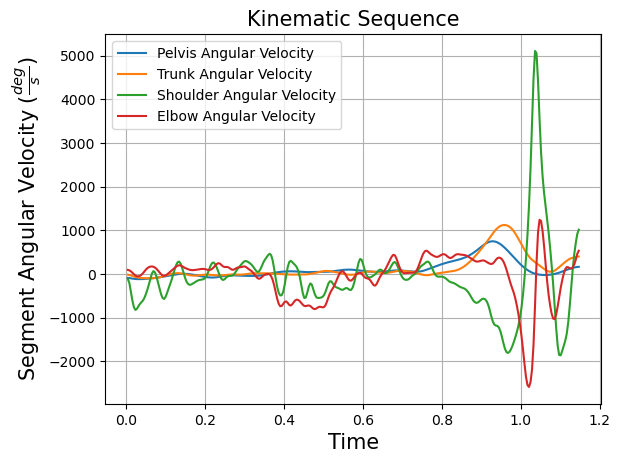

In [17]:
'''
# Define time vector `t`


# Extract the time series segment you want to compute the derivative for


# Calculate the derivative of the time series
pelvis_velo = x_dot(pelvis_test, t_z)
'''


# Create a new time series for the derivative (midpoints)
pelvis_ang_z = signals_df['PELVIS_Z'][1:301]
trunk_ang_z = signals_df['TRUNK_Z'][1:301]
shoulder_ang_z = signals_df['SHOULDER_Z'][1:301]
elbow_ang_x = signals_df['ELBOW_X'][1:301]

t0 = signals_df['ZERO_TIME'][1:301]
segment_data = np.array([pelvis_ang_z, trunk_ang_z, shoulder_ang_z, elbow_ang_x])

KS = []
for i in range(len(segment_data)):
    KS.append(x_dot(t0, segment_data[i]))

KS = np.array(KS)

pelvis_ang_velo = x_dot(t0, pelvis_ang_z)
segments = np.array(['Pelvis', 'Trunk', 'Shoulder', 'Elbow'])
# Plot the derivative against its corresponding time points
plt.figure()
for i in range(len(KS)):
    plt.plot(t0, KS[i], label=f'{segments[i]} Angular Velocity') #,linestyle =  'dashed'
    #plt.scatter(t0, KS[i], label=f'{segments[i]} Angular Velocity', s=10)
plt.xlabel('Time', size = 15)
plt.ylabel(r'Segment Angular Velocity' r' ($\frac{deg}{s}$)',size=15) 
plt.title('Kinematic Sequence', size = 15)
plt.grid()
plt.legend()
plt.show()


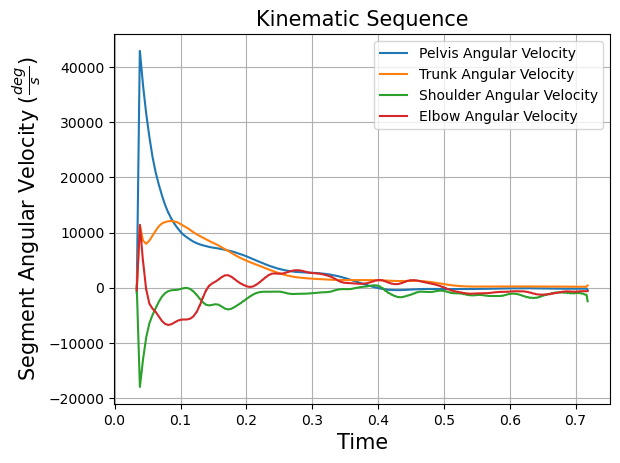

In [23]:

# Create a new time series for the derivative (midpoints)
pelvis_ang_z = signals_df['PELVIS_Z'][4830:5117]
trunk_ang_z = signals_df['TRUNK_Z'][4830:5117]
shoulder_ang_z = signals_df['SHOULDER_Z'][4830:5117]
elbow_ang_x = signals_df['ELBOW_X'][4830:5117]

t0 = signals_df['ZERO_TIME'][4830:5117]
segment_data = np.array([pelvis_ang_z, trunk_ang_z, shoulder_ang_z, elbow_ang_x])

KS = []
for i in range(len(segment_data)):
    KS.append(x_dot(t0, segment_data[i]))

KS = np.array(KS)

pelvis_ang_velo = x_dot(t0, pelvis_ang_z)
segments = np.array(['Pelvis', 'Trunk', 'Shoulder', 'Elbow'])
# Plot the derivative against its corresponding time points
plt.figure()
for i in range(len(KS)):
    plt.plot(t0, KS[i], label=f'{segments[i]} Angular Velocity') #,linestyle =  'dashed'
    #plt.scatter(t0, KS[i], label=f'{segments[i]} Angular Velocity', s=10)
plt.xlabel('Time', size = 15)
plt.ylabel(r'Segment Angular Velocity' r' ($\frac{deg}{s}$)',size=15) 
plt.title('Kinematic Sequence', size = 15)
plt.grid()
plt.legend()
plt.show()

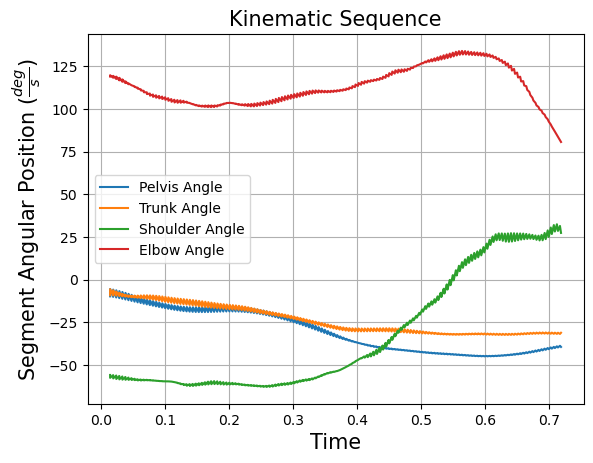

In [20]:

# Create a new time series for the derivative (midpoints)
pelvis_ang_z = signals_df['PELVIS_Z'][4821:5117]
trunk_ang_z = signals_df['TRUNK_Z'][4821:5117]
shoulder_ang_z = signals_df['SHOULDER_Z'][4821:5117]
elbow_ang_x = signals_df['ELBOW_X'][4821:5117]

t0 = signals_df['ZERO_TIME'][4821:5117]
segment_data = np.array([pelvis_ang_z, trunk_ang_z, shoulder_ang_z, elbow_ang_x])

KS = []
for i in range(len(segment_data)):
    KS.append(x_dot(t0, segment_data[i]))

KS = np.array(KS)

pelvis_ang_velo = x_dot(t0, pelvis_ang_z)
segments = np.array(['Pelvis', 'Trunk', 'Shoulder', 'Elbow'])
# Plot the derivative against its corresponding time points
plt.figure()
for i in range(len(segment_data)):
    plt.plot(t0, segment_data[i], label=f'{segments[i]} Angle') #,linestyle =  'dashed'
    #plt.scatter(t0, KS[i], label=f'{segments[i]} Angular Velocity', s=10)
plt.xlabel('Time', size = 15)
plt.ylabel(r'Segment Angular Position' r' ($\frac{deg}{s}$)',size=15) 
plt.title('Kinematic Sequence', size = 15)
plt.grid()
plt.legend()
plt.show()

In [155]:
# Ensure that we properly group by each unique pitch and reset metrics
# Create a unique pitch identifier based on PITCHER_PITCH_COUNT and ZERO_TIME == 0
smoothed_data['PITCH_IDENTIFIER'] = (smoothed_data['ZERO_TIME'] == 0).cumsum()

# Define a function to calculate metrics for each unique pitch
def calculate_pitch_metrics(pitch_df):
    # Calculate the derivatives using the provided x_dot function for each segment
    pitch_df['PELVIS_Z_DERIVATIVE'] = x_dot(pitch_df['ZERO_TIME'], pitch_df['PELVIS_Z'])
    pitch_df['TRUNK_Z_DERIVATIVE'] = x_dot(pitch_df['ZERO_TIME'], pitch_df['TRUNK_Z'])
    pitch_df['SHOULDER_Z_DERIVATIVE'] = x_dot(pitch_df['ZERO_TIME'], pitch_df['SHOULDER_Z'])
    pitch_df['ELBOW_X_DERIVATIVE'] = x_dot(pitch_df['ZERO_TIME'], pitch_df['ELBOW_X'])
    return pitch_df

# Apply the pitch-level calculation for each unique pitch
smoothed_data_grouped = smoothed_data.groupby(['INNING', 'PITCH_TYPE', 'PITCH_IDENTIFIER']).apply(calculate_pitch_metrics)

# Redefine the aggregation dictionary to include derivative calculations per pitch
aggregation_dict_corrected = {
    'RELEASE_SPEED': 'mean',
    'SPIN_RATE': 'mean',
    # Peak derivatives for each segment
    'ELBOW_X_DERIVATIVE': 'max',
    'PELVIS_Z_DERIVATIVE': 'max',
    'TRUNK_Z_DERIVATIVE': 'max',
    'SHOULDER_Z_DERIVATIVE': 'max',
    # Flexion and extension for elbow
    'ELBOW_X': [
        ('Max Flexion', 'max'),
        ('Min Extension', 'min')
    ],
    # Other key metrics
    'FRONTKNEE_X': [
        ('Max Hyperextension', 'max'),
        ('Min Flexion', 'min')
    ],
    'BACKKNEE_X': [
        ('Max Hyperextension', 'max'),
        ('Min Flexion', 'min')
    ],
    # Trunk metrics
    'TRUNK_X': 'max',
    'TRUNK_Y': 'max',
    'TRUNK_Z': 'max',
    # Shoulder horizontal adduction/abduction
    'SHOULDER_X': [
        ('Max Horizontal Adduction', 'max'),
        ('Min Horizontal Abduction', 'min')
    ],
    # Shoulder internal/external rotation
    'SHOULDER_Z': [
        ('Max Internal Rotation', 'max'),
        ('Min External Rotation', lambda x: x[x < 0].min())
    ],
    # Elbow varus torque
    'ELBOWMOMENT_Y': 'max'
}

# Apply the aggregation across grouped pitch-level data
combined_metrics_corrected = smoothed_data_grouped.groupby(['INNING', 'PITCH_TYPE']).agg(aggregation_dict_corrected).reset_index()

# Flatten the multi-level column names for easier readability
combined_metrics_corrected.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in combined_metrics_corrected.columns]

# Display the corrected DataFrame
print("\n=== Combined Metrics with Corrected Pitch-Level Resets ===\n")
print(combined_metrics_corrected.head())

# Save the corrected metrics to a new Excel file
output_combined_corrected_path = "/mnt/data/Corrected_Peak_Metrics_Pitch_Level_Resets.xlsx"
combined_metrics_corrected.to_excel(output_combined_corrected_path, index=False)
print(f"\nCorrected Peak Metrics with Pitch-Level Resets have been saved to: {output_combined_corrected_path}")


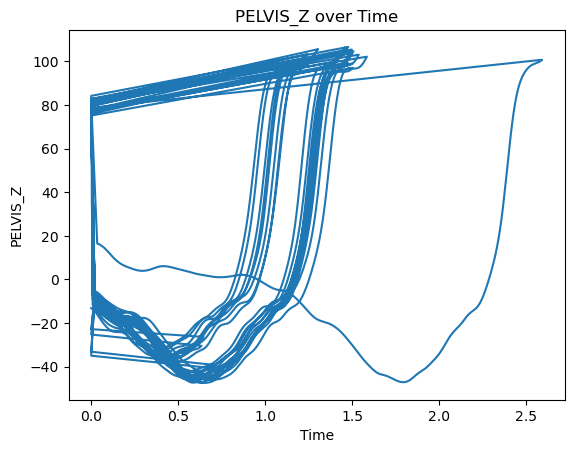

In [172]:
plt.plot(smoothed_data['ZERO_TIME'], smoothed_data['PELVIS_Z'])
plt.title('PELVIS_Z over Time')
plt.xlabel('Time')
plt.ylabel('PELVIS_Z')
plt.show()
